## BUILD - TRAIN - TEST Recurrent Nerural Networks
### Time Series Data with LSTM & Keras

In [1]:
# IMPORT BASIC lIBRARIES

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# For timeseries RNN LSTM nerual network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

2023-03-06 04:04:27.188637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 04:04:27.337672: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-06 04:04:27.337723: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-06 04:04:28.331324: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
# IMPORT KERAS: TimeseriesGenerator
# This class produces time series batches used on training/testing model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# IMPORT KERAS: MinMaxScaler
# This class is used to preprocess (scale) the data
from sklearn.preprocessing import MinMaxScaler

### Data Set: APPL (Apple Stock: 01/01/2014-06/30/2019)

In [4]:
dir_path_dataset_1 = 'GME1.1.2014_06.30.2019.csv'

### Load Dataset

In [5]:
df_ALL = pd.read_csv(dir_path_dataset_1)

In [6]:
df_ALL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2014,12.2875,12.4400,12.0275,12.4125,8.941858,11337200
1,1/3/2014,12.4275,12.5000,12.2675,12.3100,8.868019,5271200
2,1/6/2014,12.3100,12.3250,11.9950,12.0425,8.675315,11595600
3,1/7/2014,12.1125,12.2700,10.9000,11.0350,7.949521,60224000
4,1/8/2014,10.9800,11.4075,10.9050,11.3375,8.167438,29900800


### Brief Exploratory Data Analysis (EDA)

In [7]:
df_ALL.shape

(1382, 7)

In [8]:
df_ALL.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [9]:
# Satistics Summary
df_ALL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1.382000e+03
mean,6.813578,6.913388,6.706187,6.809173,5.381252,1.262179e+07
std,2.856218,2.890183,2.815630,2.854559,1.889007,1.159506e+07
min,1.245000,1.282500,1.177500,1.255000,1.255000,2.984400e+06
25%,4.108750,4.188125,4.044375,4.108125,3.743756,7.210900e+06
50%,6.531250,6.613750,6.423750,6.515000,5.199118,9.724200e+06
75%,9.492500,9.644375,9.321875,9.493750,6.980447,1.404310e+07
max,12.427500,12.500000,12.267500,12.412500,8.980933,1.574168e+08


### Keep Only "Close" (for Closing Price) and Filter Out All Other Atributes
#### Notes: the research focuses only on the closing price

In [10]:
df = df_ALL.iloc[:,4:5]

In [11]:
df.head()

,Close
0,12.4125
1,12.3100
2,12.0425
3,11.0350
4,11.3375


<AxesSubplot:>

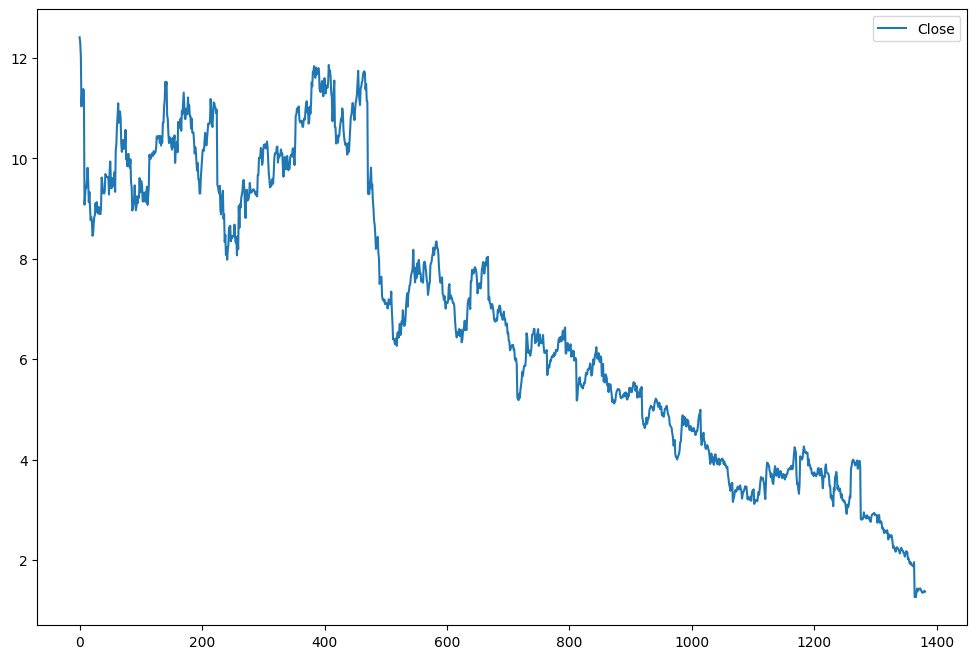

In [12]:
df.plot(figsize=(12,8))

### Length of Input Time Series - Number of Input Time Steps 

In [13]:
# Set the length of the input sequence 
# i.e., the number of time series steps that are used to predict the future one
# Currently use 70 historical data points to predict the next one
# It means that 70 consecutive closing prices will be used to predict the next one

length80 = 80

In [14]:
length80

80

### Time Series Dataset: Train / Test Split

In [15]:
len(df)

1382

In [16]:
# Set percentage of data used for testing

test_percent = 0.3

In [17]:
# Number of data points reserved for testing the model
# 20% of the original dataset

len(df)*test_percent 

414.59999999999997

### Split Data--> Train/Test 

In [18]:
# Need to find the length (number of data points) of the testing dataset
# It has been found (above) that around 205 data points are used for testing

test_length = np.round(len(df)*test_percent)
test_length

415.0

In [19]:
# The testing data set starts at this index

# test_start_index = int(len(df) - test_length)
split_index = int(len(df) - test_length)

split_index

967

In [20]:
# Create separate training / testing datasets

# Training dataset: All the indices from start to split_index
# (excluding split_index)
data_train = df.iloc[: split_index]

# Testing dataset:
# --> All the indices from (split_index - length80) to the end of the dataframe
# --> split_index - length80: Need the last 80 historical data points (belong to the data_train)
#     to predict the first data point of the data_test

data_test = df.iloc[split_index - length80 :]


In [21]:
data_train.head(5)

,Close
0,12.4125
1,12.3100
2,12.0425
3,11.0350
4,11.3375


In [22]:
data_train.tail()

,Close
962,4.8775
963,4.8350
964,4.6925
965,4.6725
966,4.6500


In [23]:
data_test.head(5)

,Close
887,5.2475
888,5.2900
889,5.2550
890,5.3200
891,5.2725


In [24]:
data_test.tail()

,Close
1377,1.3425
1378,1.3625
1379,1.3675
1380,1.3850
1381,1.3675


### Normalize Data (Scale it into the range [0,1])

In [25]:
# Create a MinMaxScaler to normalize the data
scaler = MinMaxScaler()

In [26]:
# IGNORE the warning: Just cponverting the data to flaots
# Only scale the training data - NOT scale testing data

#Train the scaler to perform the normalization
scaler.fit(data_train)

MinMaxScaler()

In [27]:
# Normalize the training dataset
normalized_train = scaler.transform(data_train)

# Normalize the testing dataset
normalized_test = scaler.transform(data_test)

### Create TimseriesGenerator for Training 

In [28]:
# TimeseriesGenerator: Generate time series batches for training/testing

# Set the length of the input sequence as above
# length80

# batch_size: number of time series samples in each batch
# Sample: A single time series input that has 60 historical data points
batch_size33 = 33

# Create a TimeSeriesGenerator for training: train_tsGenerator 
# --> This time series generator produce time series batches used to train the model
# TimeseriesGenerator(inputs, outputs, length, batch_size)
# --> Normally: INPUTS & OUTPUTS are the same dataset during training & testing/validation

train_tsGenerator60 = TimeseriesGenerator(normalized_train, normalized_train, length=length80, batch_size=batch_size33)

In [29]:
len(normalized_train)

967

In [30]:
len(train_tsGenerator60)

27

In [31]:
# What does the first batch look like?
X,y = train_tsGenerator60[0]

In [32]:
# print(X)

In [33]:
# print(y)

## Build, Train, and Test Model
### Build LSTM Model 

In [34]:
# Set number of features
# Feature: Attribute/Variable of the data set - used as predictors

# Only using one feature: Close price 
n_features = 1

In [35]:
# define model
model = Sequential()

# Add an LSTM layer
# This layer has 70 LSTM cells
# Activation function: relu
# MUST: return_sequences=True
# --> Because of multiple LSTM layers: the layers are stacked
# --> Outputs = inputs of the next LSTM layer
model.add(LSTM(70, activation='relu', return_sequences=True, input_shape=(length80, n_features)))

# Drop layer
model.add(Dropout(0.4))

# Add 2nd LSTM layer
# Must: return_sequences=True
# --> Because of multiple LSTM layers: the layers are stacked
# --> Outputs = inputs of the next LSTM layer
model.add(LSTM(units=70, activation='relu', return_sequences=True))

# Drop layer
model.add(Dropout(0.4))

# Add 3rd LSTM layer
model.add(LSTM(units=70, activation='relu'))

# Add a FC (fully connected) layer for the final prediction
model.add(Dense(1))

2023-03-06 04:04:29.851148: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 04:04:29.851188: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 04:04:29.851217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jbinstance2): /proc/driver/nvidia/version does not exist
2023-03-06 04:04:29.851488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


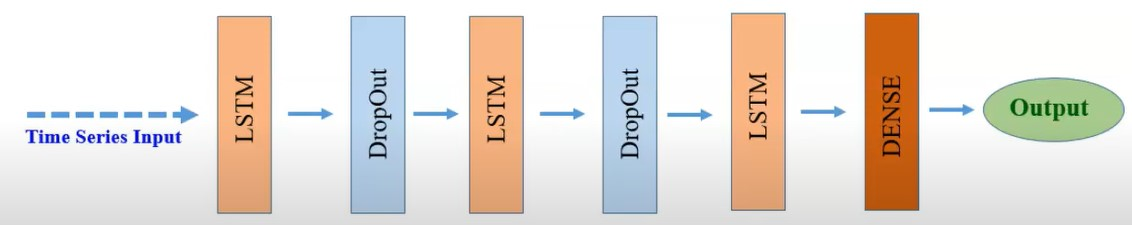

### Compile Model

In [36]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 70)            20160     
                                                                 
 dropout (Dropout)           (None, 80, 70)            0         
                                                                 
 lstm_1 (LSTM)               (None, 80, 70)            39480     
                                                                 
 dropout_1 (Dropout)         (None, 80, 70)            0         
                                                                 
 lstm_2 (LSTM)               (None, 70)                39480     
                                                                 
 dense (Dense)               (None, 1)                 71        
                                                                 
Total params: 99,191
Trainable params: 99,191
Non-traina

In [37]:
# Train the model

model.fit_generator(train_tsGenerator60, epochs=130)

Epoch 1/130


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


27/27 [==============================] - 6s 98ms/step - loss: 0.0883
Epoch 2/130
27/27 [==============================] - 3s 99ms/step - loss: 0.0340
Epoch 3/130
27/27 [==============================] - 3s 96ms/step - loss: 0.0113
Epoch 4/130
27/27 [==============================] - 3s 96ms/step - loss: 0.0099
Epoch 5/130
27/27 [==============================] - 3s 98ms/step - loss: 0.0069
Epoch 6/130
27/27 [==============================] - 3s 98ms/step - loss: 0.0078
Epoch 7/130
27/27 [==============================] - 3s 100ms/step - loss: 0.0081
Epoch 8/130
27/27 [==============================] - 3s 97ms/step - loss: 0.0070
Epoch 9/130
27/27 [==============================] - 3s 99ms/step - loss: 0.0061
Epoch 10/130
27/27 [==============================] - 3s 98ms/step - loss: 0.0077
Epoch 11/130
27/27 [==============================] - 5s 182ms/step - loss: 0.0071
Epoch 12/130
27/27 [==============================] - 3s 101ms/step - loss: 0.0056
Epoch 13/130
27/27 [==============

### Visualize Model's Performance after Training 

In [38]:
loss_history_keys = model.history.history.keys()

# model.history.history is a dict
# 'loss': its key
# 'loss': loss during training;
loss_history_keys


dict_keys(['loss'])

<AxesSubplot:>

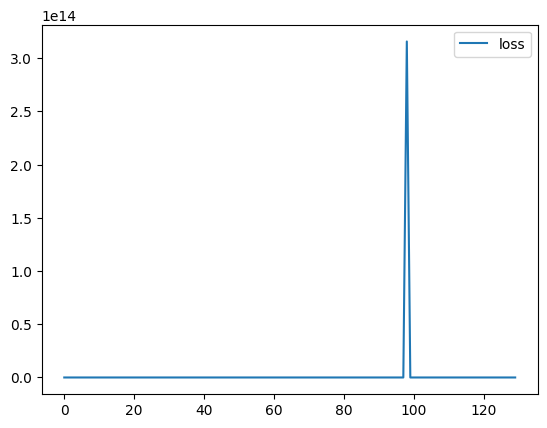

In [39]:
# Load the loss data (model.history.history) into a data frame
df_model_loss = pd.DataFrame(model.history.history)

# Visualize the loss data using DataFrame.plot()
df_model_loss.plot()

## Prediction for Testing: Using TimeseriesGenerator

### Create TimseriesGenerator for Testing

In [40]:
# batch_size MUSt be 1
batch_size1 = 1

# Create a TimeseriesGenerator for testing: test_tsGenerator
test_tsGenerator60 = TimeseriesGenerator(normalized_test, normalized_test, length=length80, batch_size=batch_size1)

### Predict Future Data Points for Testing

In [41]:
normalized_prediction = model.predict_generator (test_tsGenerator60)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [42]:
# Prediction is a numpy 2D array with only one column

normalized_prediction

array([[ 3.43191102e-02],
       [ 3.29605266e-02],
       [ 3.15050967e-02],
       [ 2.99477242e-02],
       [ 2.83155870e-02],
       [ 2.67006978e-02],
       [ 2.53380518e-02],
       [ 2.39870995e-02],
       [ 2.26024315e-02],
       [ 2.12545060e-02],
       [ 2.00062767e-02],
       [ 1.88529603e-02],
       [ 1.78093165e-02],
       [ 1.69316977e-02],
       [ 1.62835009e-02],
       [ 1.59516800e-02],
       [ 1.58826280e-02],
       [ 1.61362905e-02],
       [ 1.67893320e-02],
       [ 1.79732833e-02],
       [ 1.94077697e-02],
       [ 2.08071843e-02],
       [ 2.22258531e-02],
       [ 2.35656910e-02],
       [ 2.46943403e-02],
       [ 2.54592355e-02],
       [ 2.60816161e-02],
       [ 2.65942719e-02],
       [ 2.70390008e-02],
       [ 2.72800922e-02],
       [ 2.72340346e-02],
       [ 2.69472916e-02],
       [ 2.66229492e-02],
       [ 2.62530819e-02],
       [ 2.58216858e-02],
       [ 2.54282542e-02],
       [ 2.50532813e-02],
       [ 2.47756615e-02],
       [ 2.4

In [43]:
len(normalized_prediction)

415

In [44]:
# Convert normalizes predictino back to the true values

prediction = scaler.inverse_transform(normalized_prediction)

In [45]:
# Flatten all the 2D array

#data_train = data_train.reshape((-1))
#data_test = data_test.reshape((-1))
#data_prediction = prediction.reshape((-1))

prediction_index = np.arange(967, 1382, step=1)

df_prediction = pd.DataFrame(data=prediction,index=prediction_index, columns=['Prediction'])

In [46]:
df_prediction

,Prediction
967,4.892260
968,4.881680
969,4.870346
970,4.858218
971,4.845508
...,...
1377,-1991.751709
1378,-2213.439453
1379,-2495.828857
1380,-2447.312256


### Visualize Prediction

<AxesSubplot:>

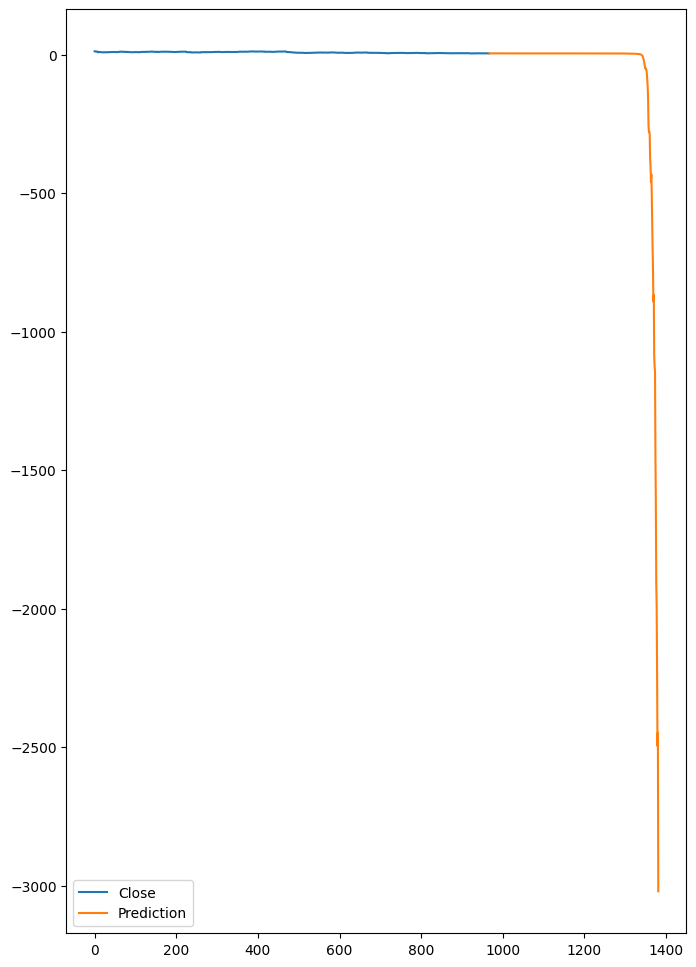

In [47]:
ax = data_train.plot()

df_prediction.plot(ax=ax, figsize=(8,12))

### Visualize Prediction and Compare Actual Close Price 

<AxesSubplot:>

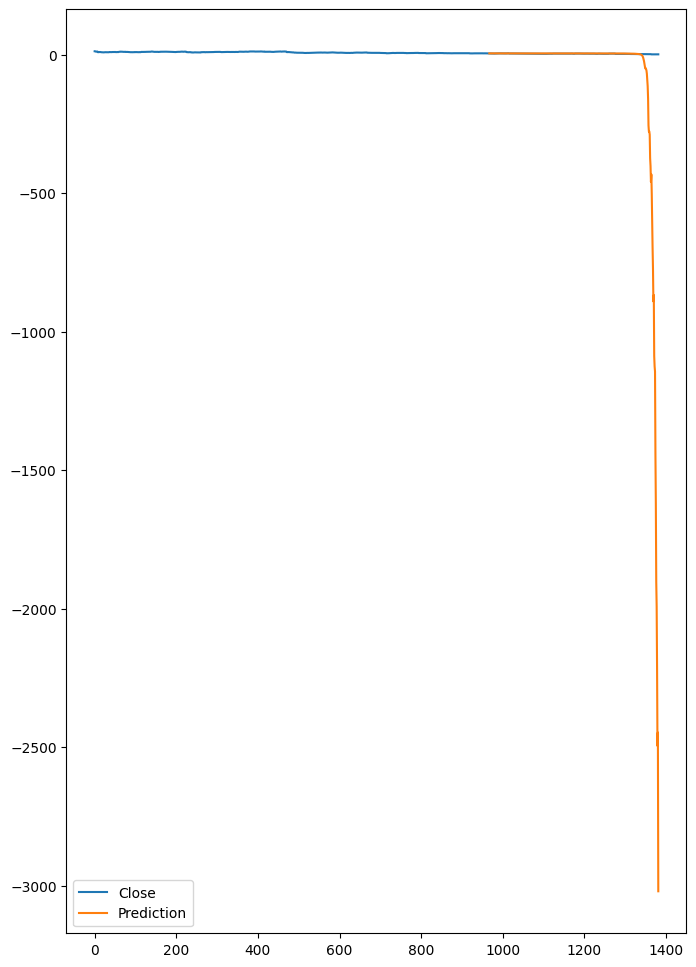

In [48]:
ax = df.plot()
df_prediction.plot(ax=ax, figsize=(8,12))

## Time Series Forcasting with LSTM

### Overview

#### Time series forecasting:
--> Forecast into the "future" or unknown range
<br>
--> Should employ all the available data
<br>
--> i.e., Not split the data into training/testing 

### Preprocess Full Input Dataset

In [49]:
#Still use MinMaxScaler to normalize the full input dataset df

full_scaler = MinMaxScaler()
normalized_full_data = full_scaler.fit_transform(df)

### Create TimeSeriesGenerator for Froecasting

In [50]:
# Number of time steps of the input time series
# Still use length80:
length80

80

In [51]:
# Create TimeseriesGnerator for forecasting
forecast_tsGenerator = TimeseriesGenerator(normalized_full_data, normalized_full_data, length=length80, batch_size=batch_size33)

### Build, Compile, and Fit LSTM Model for Forecasting

In [52]:
# Train/Fit LSTM model
# In forecasting, we don't validate, only FORECAST
# So, no need EarlyStop; Not need validation_generator

model.fit_generator(forecast_tsGenerator, epochs =130)

Epoch 1/130
 1/40 [..............................] - ETA: 4s - loss: 0.0022

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


40/40 [==============================] - 4s 97ms/step - loss: 0.0018
Epoch 2/130
40/40 [==============================] - 4s 97ms/step - loss: 0.0017
Epoch 3/130
40/40 [==============================] - 4s 97ms/step - loss: 0.0016
Epoch 4/130
40/40 [==============================] - 4s 98ms/step - loss: 0.0020
Epoch 5/130
40/40 [==============================] - 4s 97ms/step - loss: 0.0017
Epoch 6/130
40/40 [==============================] - 4s 98ms/step - loss: 0.0019
Epoch 7/130
40/40 [==============================] - 4s 98ms/step - loss: 0.0021
Epoch 8/130
40/40 [==============================] - 4s 97ms/step - loss: 0.0018
Epoch 9/130
40/40 [==============================] - 4s 98ms/step - loss: 0.0017
Epoch 10/130
40/40 [==============================] - 4s 97ms/step - loss: 0.0016
Epoch 11/130
40/40 [==============================] - 4s 98ms/step - loss: 0.0014
Epoch 12/130
40/40 [==============================] - 4s 96ms/step - loss: 0.0016
Epoch 13/130
40/40 [=================

### Timeseries Forcast using LSTM Nerual Network: 07/01/2019 - 12/15/2019

In [53]:
forecast = []

# Set periods wit the sime span of forecasting
# Let's forecast for the next 107 business days (07/01/2019 - 12/15/2019)
periods = 117

first_eval_batch = normalized_full_data[-length80:]
current_batch = first_eval_batch.reshape((1, length80, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead([0] is for grabbing just thenumber instead od [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred)
    
    # update batch to now include prediction and drop the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

1/1 [==============================] - 0s 31ms/step


### Inverse to Transform Normalized Data Back into True Values

In [54]:
forecast = full_scaler.inverse_transform(forecast)

forecast

array([[1.28236703],
       [1.27633794],
       [1.26986711],
       [1.26302083],
       [1.25597956],
       [1.24893638],
       [1.24205448],
       [1.23544233],
       [1.22916407],
       [1.22324377],
       [1.21767981],
       [1.21245102],
       [1.20753248],
       [1.20289645],
       [1.19851568],
       [1.19437273],
       [1.19044988],
       [1.18673464],
       [1.18321467],
       [1.17988432],
       [1.17673437],
       [1.17375212],
       [1.1709312 ],
       [1.16826177],
       [1.1657367 ],
       [1.1633446 ],
       [1.16108047],
       [1.15893797],
       [1.15691006],
       [1.15498826],
       [1.15316747],
       [1.1514424 ],
       [1.14980694],
       [1.14825474],
       [1.14678156],
       [1.14538452],
       [1.14406026],
       [1.14280558],
       [1.14161616],
       [1.14048867],
       [1.13941696],
       [1.13839833],
       [1.13743207],
       [1.13651498],
       [1.1356459 ],
       [1.13482187],
       [1.13403987],
       [1.133

In [55]:
df

,Close
0,12.4125
1,12.3100
2,12.0425
3,11.0350
4,11.3375
...,...
1377,1.3425
1378,1.3625
1379,1.3675
1380,1.3850


### Creating new timestamp index with pandas: 07/01/2019 - 12/15/2019

In [56]:
# Calculate forecast index

forecast_index = np.arange(1382, 1499, step=1)

In [57]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

In [58]:
forecast_df

,Forecast
1382,1.282367
1383,1.276338
1384,1.269867
1385,1.263021
1386,1.255980
...,...
1494,1.119906
1495,1.119882
1496,1.119860
1497,1.119839


### Plot the Forecast

<AxesSubplot:>

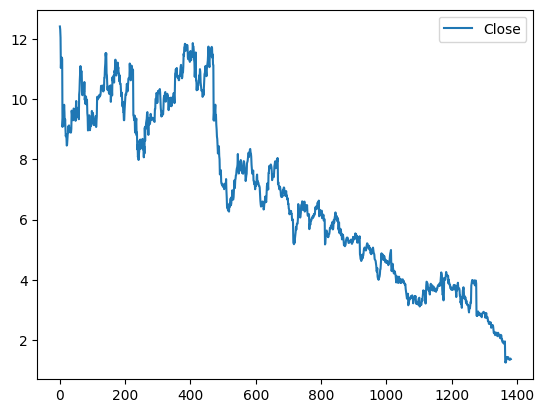

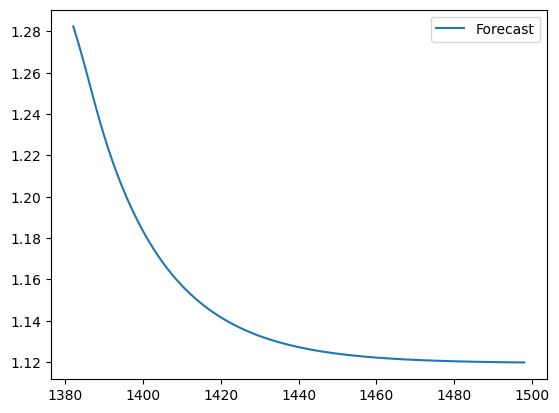

In [59]:
df.plot()
forecast_df.plot()

### Joining Pandas Plots

<AxesSubplot:>

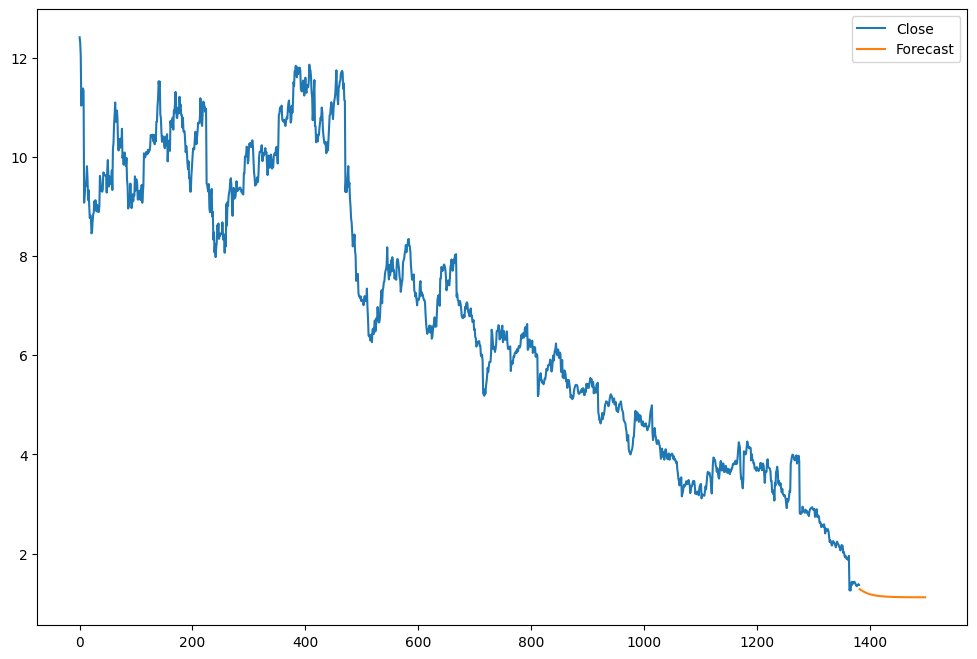

In [60]:
ax = df.plot()
forecast_df.plot(ax=ax, figsize=(12,8))

In [61]:
dir_path_dataset_2 = 'GME7.1.2019_12.15.2019.csv'

In [62]:
df_ALL_JUL_DEC_2019 = pd.read_csv(dir_path_dataset_2)

In [63]:
df_ALL_JUL_DEC_2019.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,7/1/2019,1.3825,1.3925,1.3350,1.3400,1.3400,17243200
1,7/2/2019,1.3375,1.3625,1.3300,1.3450,1.3450,22574000
2,7/3/2019,1.3525,1.3575,1.3175,1.3275,1.3275,10248400
3,7/5/2019,1.3250,1.4100,1.3175,1.3800,1.3800,51578400
4,7/8/2019,1.3750,1.3825,1.3550,1.3625,1.3625,26370800


In [64]:
df_JUL_DEC_2019 = df_ALL_JUL_DEC_2019.iloc[:,4:5]

In [65]:
df_JUL_DEC_2019

,Close
0,1.3400
1,1.3450
2,1.3275
3,1.3800
4,1.3625
...,...
112,1.5825
113,1.6275
114,1.3825
115,1.3950


<AxesSubplot:>

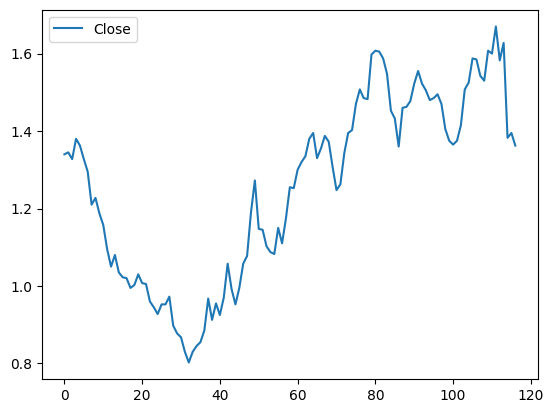

In [66]:
df_JUL_DEC_2019.plot()

In [67]:
forecast_df['Forecast'].values

array([1.28236703, 1.27633794, 1.26986711, 1.26302083, 1.25597956,
       1.24893638, 1.24205448, 1.23544233, 1.22916407, 1.22324377,
       1.21767981, 1.21245102, 1.20753248, 1.20289645, 1.19851568,
       1.19437273, 1.19044988, 1.18673464, 1.18321467, 1.17988432,
       1.17673437, 1.17375212, 1.1709312 , 1.16826177, 1.1657367 ,
       1.1633446 , 1.16108047, 1.15893797, 1.15691006, 1.15498826,
       1.15316747, 1.1514424 , 1.14980694, 1.14825474, 1.14678156,
       1.14538452, 1.14406026, 1.14280558, 1.14161616, 1.14048867,
       1.13941696, 1.13839833, 1.13743207, 1.13651498, 1.1356459 ,
       1.13482187, 1.13403987, 1.13329839, 1.13259167, 1.13191931,
       1.13128208, 1.13067735, 1.13010604, 1.12956387, 1.12905046,
       1.12856369, 1.12810045, 1.12765965, 1.12724151, 1.12684286,
       1.12646275, 1.12610006, 1.12575349, 1.12543439, 1.12513105,
       1.12484388, 1.12457001, 1.12430894, 1.12406229, 1.12382712,
       1.12360375, 1.12339127, 1.1231896 , 1.12299861, 1.12281

In [68]:
df_JUL_DEC_2019['Forecast'] = forecast_df['Forecast'].values

In [69]:
df_JUL_DEC_2019

,Close,Forecast
0,1.3400,1.282367
1,1.3450,1.276338
2,1.3275,1.269867
3,1.3800,1.263021
4,1.3625,1.255980
...,...,...
112,1.5825,1.119906
113,1.6275,1.119882
114,1.3825,1.119860
115,1.3950,1.119839


<AxesSubplot:>

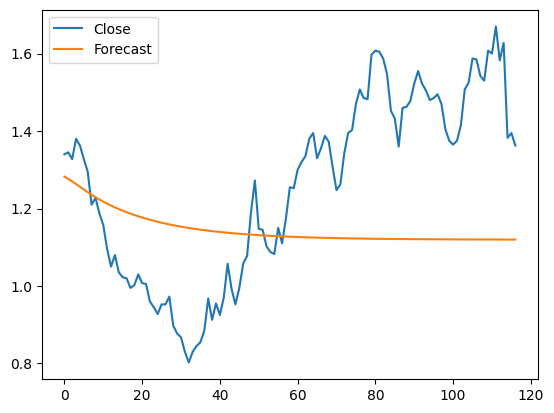

In [70]:
df_JUL_DEC_2019.plot()